In [1]:
#信用卡用户画像案例分析
'''案例背景：
    clients: client_id(客户号) sex（性别） birth_data（出生日期） disrtict_id(客户所属地区)
    disp: disp_id(权限号) client_id(客户号) account_id(账户号) type(权限类型)
    trans: trans_id(交易序号) account_id(账户号) date(交易日期) type(借贷类型) operation(交易类型) 
           amount(金额) balance(账户余额) K_symbol(交易特征) bank(对方银行) account(对方账户号)
    card: card_id(信用卡id) disp_id(权限号) type(卡类型) issued(发卡日期)
'''
import pandas as pd
import os

os.chdir('E:\新建文件夹\案例\信用卡用户画像')

In [2]:
import sqlite3
con = sqlite3.connect(':memory:') #内存中创建数据库

In [3]:
#导入数据
card = pd.read_csv(r'card.csv',encoding='gbk')
disp = pd.read_csv(r'disp.csv',encoding='gbk')
clients = pd.read_csv(r'clients.csv',encoding='gbk')
trans = pd.read_csv(r'trans.csv',encoding='gbk',low_memory=False)
card.to_sql('card', con)
disp.to_sql('disp', con)
clients.to_sql('clients', con)
trans.to_sql('trans', con)  

In [4]:
car_sql = '''
select a.*,c.sex,c.birth_date,c.district_id
    from card as a
    left join disp as d on a.disp_id=d.disp_id
    left join clients as c on d.client_id = c.client_id
    where d.type = '所有者'
'''
card_new = pd.read_sql(car_sql,con)                 
card_new.head()

,index,card_id,disp_id,issued,type,sex,birth_date,district_id
0,777,1,9,1998-10-16,金卡,男,1935-10-16,60
1,508,2,19,1998-03-13,普通卡,男,1942-12-28,47
2,64,3,41,1995-09-03,金卡,男,1968-08-27,22
3,840,4,42,1998-11-26,普通卡,男,1935-08-17,68
4,40,5,51,1995-04-24,青年卡,女,1979-12-02,36


In [5]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  #黑体
mpl.rcParams['axes.unicode_minus'] = False #解决中文显示异常的问题

In [6]:
from datetime import *
card_new['issued_date']=pd.to_datetime(card_new['issued'])  #标准化日期
card_new['issued_year']=card_new['issued_date'].map(lambda x:x.year)  #汇总年的情况


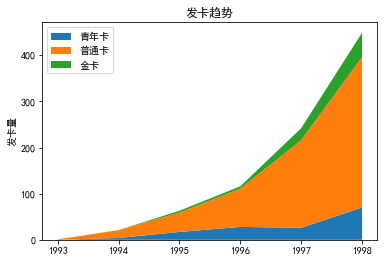

<Figure size 576x432 with 0 Axes>

In [7]:
t1 = pd.crosstab(card_new.issued_year,card_new.type) #交叉表，数量汇总
t1['sum1'] = t1.sum(axis=1)

import matplotlib.pyplot as plt
labels = ['青年卡','普通卡','金卡']
y1 = t1.loc[:,'青年卡'].astype('int')
y2 = t1.loc[:,'普通卡'].astype('int')
y3 = t1.loc[:,'金卡'].astype('int')
x = t1.index.astype('int')
plt.stackplot(x,y1,y2,y3,labels = labels)
plt.title('发卡趋势')
plt.ylabel('发卡量')
plt.legend(loc='upper left')
plt.figure(figsize=(8,6))
plt.show()

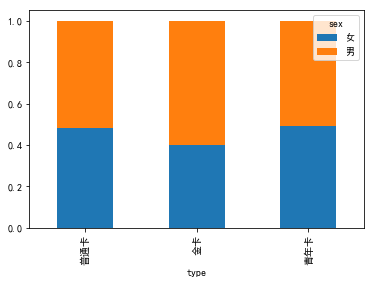

In [8]:
sub_sch = pd.crosstab(card_new.type,card_new.sex)
sub_sch.div(sub_sch.sum(1),axis = 0).plot(kind = 'bar',stacked= True) #转换成各卡的百分百

In [9]:
#链接各表取得数据
car_sql='''
select a.card_id, a.issued, a.type, c.type as t_type, c.amount, c.balance, c.date as t_date
    from card as a
    left join disp as b on a.disp_id=b.disp_id
    left join trans as c on b.account_id = c.account_id
    where b.type = '所有者'
    order by a.card_id, c.date
'''
card_t = pd.read_sql(car_sql, con)
card_t.head()

,card_id,issued,type,t_type,amount,balance,t_date
0,1,1998-10-16,金卡,贷,$900,$900,1996-11-24
1,1,1998-10-16,金卡,贷,$33975,$34875,1996-12-07
2,1,1998-10-16,金卡,借,"$6,600",$28275,1996-12-24
3,1,1998-10-16,金卡,贷,$30,$28305,1996-12-31
4,1,1998-10-16,金卡,贷,$22650,$50955,1997-01-07


In [10]:
#转换时间
card_t['issued']=pd.to_datetime(card_t['issued'])
card_t['t_date']=pd.to_datetime(card_t['t_date'])

In [11]:
#数据清洗：转换成时间，去掉逗号
import datetime
card_t['balance'] = card_t['balance'].map(lambda x:int(''.join(x[1:].split(','))))
card_t['amount'] = card_t['amount'].map(lambda x:int(''.join(x[1:].split(','))))
card_t.head()

,card_id,issued,type,t_type,amount,balance,t_date
0,1,1998-10-16,金卡,贷,900,900,1996-11-24
1,1,1998-10-16,金卡,贷,33975,34875,1996-12-07
2,1,1998-10-16,金卡,借,6600,28275,1996-12-24
3,1,1998-10-16,金卡,贷,30,28305,1996-12-31
4,1,1998-10-16,金卡,贷,22650,50955,1997-01-07


In [12]:
#发卡时间一年内的用户
card_t1 = card_t[card_t.issued>card_t.t_date]
card_t1 = card_t1[card_t.issued<card_t.t_date+datetime.timedelta(days=365)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [13]:
card_t1['avg_balance'] = card_t1.groupby('card_id')['balance'].mean() #分类汇总
card_t2=card_t1.groupby(['type','card_id'])['balance'].agg([('avg_balance','mean')])#分类后再聚合
card_t2.to_sql('card_t2', con)

In [14]:
card_t2.head()

avg_balance
type card_id              
普通卡  2        38898.610169
     4        54222.060976
     7        46888.702381
     9        55854.223881
     10       51387.500000

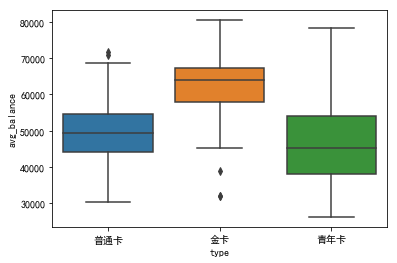

In [15]:
#银行卡账户余额对比
import seaborn as sns
card_t3 = card_t2.reset_index()
sns.boxplot(x = 'type', y ='avg_balance', data = card_t3) #自动识别数据类型